Get MEG signal from Jan's IA memory instead of the Designed Ensemble

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, VecToScalarFeed, gen_added_strings, list_as_ascii
from nengo_learn_assoc_mem.meg_ia import MegAssociativeMemory

from collections import OrderedDict

In [26]:
D = 32
ea_n_neurons = 50
seed = 8

t_present = 0.3
t_pause = 0.5
t_each = t_present + t_pause

integ_tau = 0.1
n_pairs = 16

In [27]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, \
    foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_pairs, n_pairs, D, seed, norm=True)

all_fan = fan1 + fan2
all_fan_pairs = gen_added_strings(all_fan)

all_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

target_ans = [1] * (len(fan1) + len(fan2))
foil_ans = [-1] * (len(foil1) + len(foil2))
all_ans = target_ans + foil_ans

In [28]:
feed = VecToScalarFeed(all_vecs, all_ans, t_present, t_pause)

with spa.Network("Associative Model", seed=seed) as model:
    model.famili = nengo.Node(feed.feed)
    model.correct = nengo.Node(feed.get_answer)
    model.reset = nengo.Node(lambda t: feed.paused)

    n_accum_neurons = [45] * len(fan1) + [35] * len(fan2)
    n_thresh_neurons = [15] * len(all_fan)
    model.cleanup = MegAssociativeMemory(n_accum_neurons=n_accum_neurons,
                                         n_thresholding_neurons=n_thresh_neurons,
                                         input_vocab=vocab,
                                         mapping=OrderedDict(zip(all_fan_pairs, all_fan_pairs)))

    nengo.Connection(model.famili, model.cleanup.input)
    nengo.Connection(model.reset, model.cleanup.input_reset, synapse=None)

    p_in = nengo.Probe(model.famili, synapse=None, label="input")
    p_ia_out = nengo.Probe(model.cleanup.selection.accumulators.output,
                           synapse=0.01, label="clean_accum")
    p_clean = nengo.Probe(model.cleanup.output, synapse=0.01, label="clean")
    p_cor = nengo.Probe(model.correct, synapse=None, label="correct")

    p_spikes = []

    for am_ens in model.cleanup.selection.accumulators.thresholding.ea_ensembles:
        p_spikes.append(nengo.Probe(am_ens.neurons))

In [29]:
with nengo.Simulator(model) as sim:
    sim.run(len(all_vecs)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:29.                                                 


In [38]:
t_range = sim.trange()
dt = sim.dt

fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt))

wins = (fan1_win, fan2_win, foil1_win, foil2_win)

Basic visual check the network is behaving properly

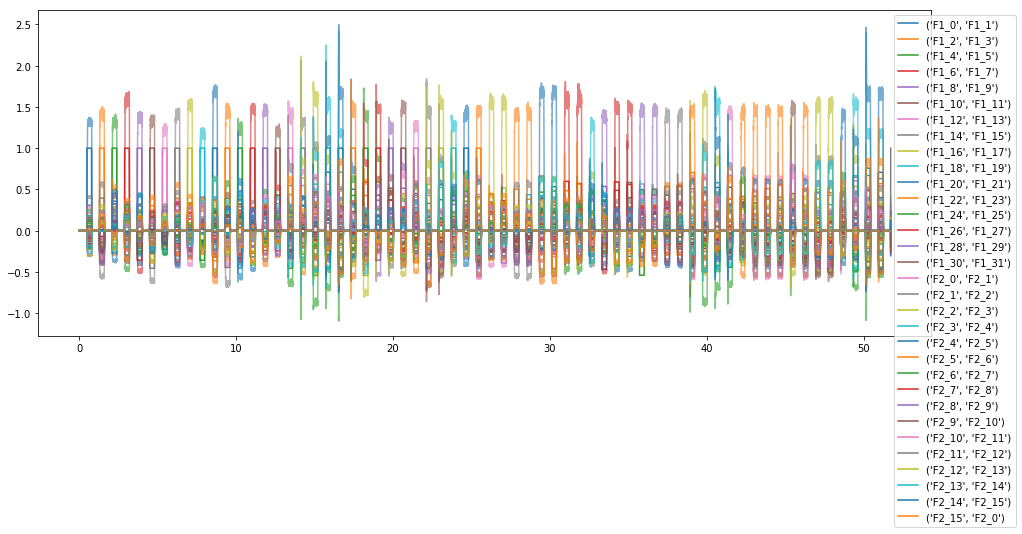

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(t_range, spa.similarity(sim.data[p_in], fan1_pair_vecs+fan2_pair_vecs))
plt.gca().set_prop_cycle(None)
plt.plot(t_range, spa.similarity(sim.data[p_clean], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6)
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

In [32]:
from nengo_learn_assoc_mem.utils import meg_from_spikes

In [33]:
all_meg = np.array([meg_from_spikes(sim.data[p_spk]) for p_spk in p_spikes])    

In [34]:
all_meg.shape

(32, 51700)

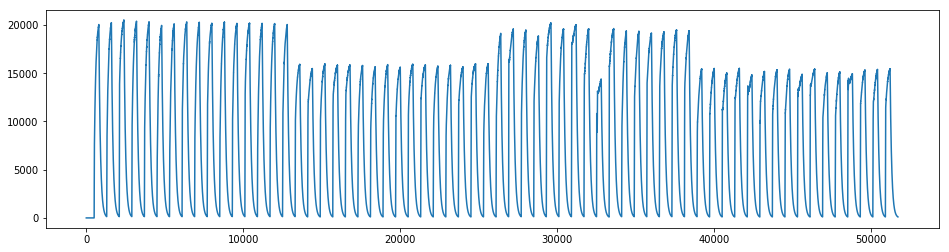

In [36]:
plt.figure(figsize=(16, 4))
plt.plot(np.sum(all_meg, axis=0))

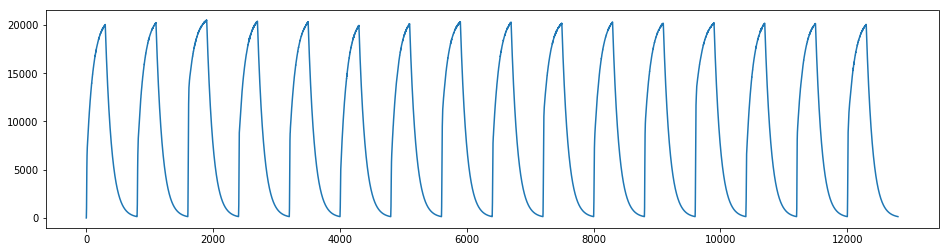

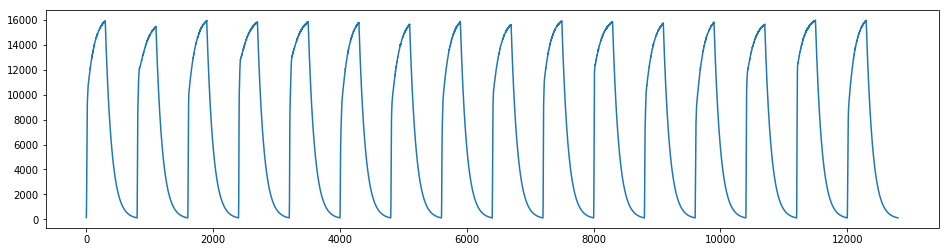

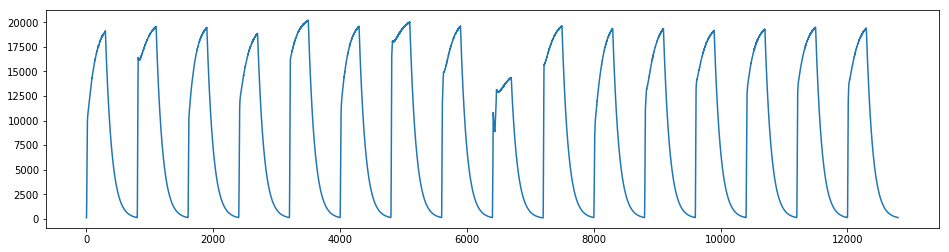

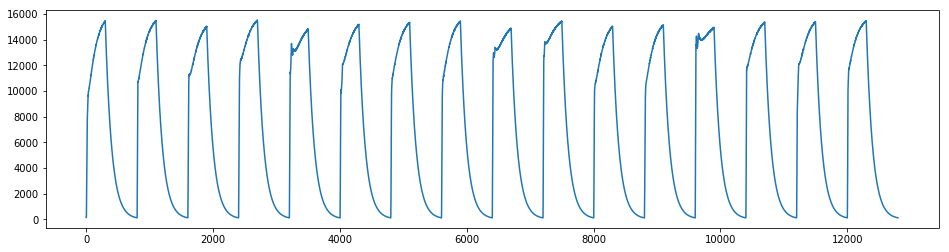

In [39]:
for win in wins:
    plt.figure(figsize=(16, 4))
    plt.plot(np.sum(all_meg[:, win], axis=0))

In [41]:
df_list = []
wins = (fan1_win, fan2_win, foil1_win, foil2_win)
targs = (True, True, False, False)
resps = (1, 2, 1, 2)

for win, targ, resp in zip(wins, targs, resps):
    act = np.sum(all_meg[:, win], axis=0)
    tt = [targ] * len(act)
    rr = [resp] * len(act)
    df_list.append(pd.DataFrame({"act": act, "targ": tt, "resp": rr}))

act_df = pd.concat(df_list)

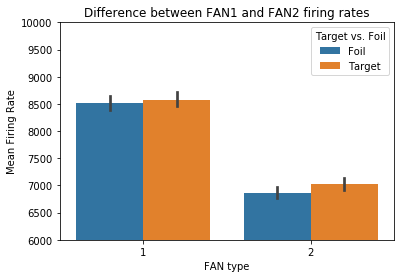

In [44]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)
ax.set_ylim((6000, 10000))

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Foil", "Target")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)